In [1]:
# Install required packages
!pip install transformers
!pip install torch
!pip install scikit-learn
!pip install pandas
!pip install nltk
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [30]:
# Import libraries
import pandas as pd
import numpy as np
import json
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score
import optuna
import matplotlib.pyplot as plt




In [3]:
# Load data from JSON file
with open('collected_books.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)


In [4]:
print (df['text'].head())

0    _To Mrs. Saville, England._ St. Petersburgh, D...
1    MOBY-DICK; or, THE WHALE. By Herman Melville C...
2    THE TRAGEDY OF ROMEO AND JULIET by William Sha...
3    [Illustration] Mr. Bennet was among the earlie...
4    THE SCARLET LETTER. BY NATHANIEL HAWTHORNE. Il...
Name: text, dtype: object


In [5]:
# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the genres
y = mlb.fit_transform(df['genres'])

# Add the encoded labels to the DataFrame
df['labels'] = y.tolist()

# Get the list of genre classes
genre_classes = mlb.classes_


In [6]:
# Compute genre distribution
genre_counts = np.sum(y, axis=0)
for genre, count in zip(genre_classes, genre_counts):
    print(f"{genre}: {count}")


Adventure: 100
Comedy: 100
Drama: 100
Fantasy: 100
Fiction: 100
Horror: 100
Mystery: 100
Nonfiction: 100
Romance: 100
Science Fiction: 100


In [21]:

class GenreDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts  # Processed texts 
        self.labels = labels  # Encoded labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        # Flatten the tensors
        item = {key: val.flatten() for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.float)
        
        return item


In [22]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Get the number of labels
num_labels = len(genre_classes)

# Initialize the model
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=num_labels,
    problem_type='multi_label_classification'
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


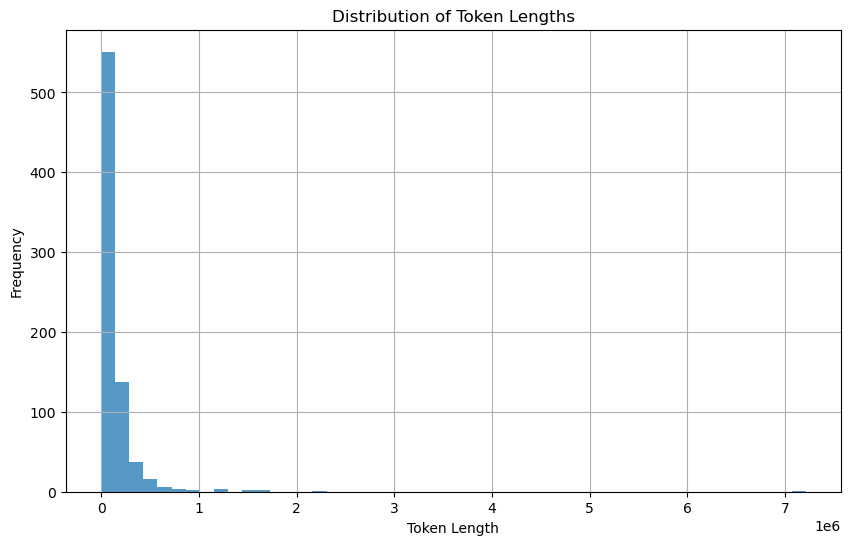

In [35]:
# Tokenize the text and compute lengths
token_lengths = df['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))

# Plot token length distribution
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, alpha=0.75)
plt.title("Distribution of Token Lengths")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [23]:
# Initialize MultilabelStratifiedShuffleSplit
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Extract the features and labels
X = df['text']
y = np.array(df['labels'].tolist())

# Perform the split
for train_idx, val_idx in msss.split(X, y):
    train_texts, val_texts = X.iloc[train_idx], X.iloc[val_idx]
    train_labels, val_labels = y[train_idx], y[val_idx]

print(f"Number of training samples: {len(train_texts)}")
print(f"Number of validation samples: {len(val_texts)}")


# Create Dataset objects
train_dataset = GenreDataset(train_texts.tolist(), train_labels, tokenizer)
val_dataset = GenreDataset(val_texts.tolist(), val_labels, tokenizer)


Number of training samples: 610
Number of validation samples: 152


In [12]:

def find_optimal_threshold(model, tokenizer, val_texts, val_labels, genre_classes, thresholds=[0.3, 0.4, 0.5, 0.6, 0.7]):
    """
    Find the optimal threshold for multi-label classification based on F1 score.

    Args:
        model (RobertaForSequenceClassification): Trained model.
        tokenizer (RobertaTokenizer): Tokenizer.
        val_texts (list of str): Validation texts.
        val_labels (numpy.ndarray): True binary labels.
        genre_classes (list): List of genre class names.
        thresholds (list of float, optional): Thresholds to evaluate. Defaults to [0.3, 0.4, 0.5, 0.6, 0.7].

    Returns:
        float: Optimal threshold.
    """
    model.eval()
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    # Preprocess the texts
    cleaned_texts = [re.sub(r'[^a-z\s]', '', text.lower()) for text in val_texts]

    # Tokenize the texts
    encoding = tokenizer(
        cleaned_texts,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        max_length=512
    )

    # Move tensors to device
    encoding = {key: val.to(device) for key, val in encoding.items()}

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()

    best_threshold = 0.5
    best_f1 = 0

    for threshold in thresholds:
        y_pred = (probs >= threshold).astype(int)
        current_f1 = f1_score(val_labels, y_pred, average='samples', zero_division=0)
        print(f"Threshold: {threshold}, F1 Score: {current_f1:.4f}")
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold

    print(f"Optimal Threshold: {best_threshold} with F1 Score: {best_f1:.4f}")
    return best_threshold

In [13]:
optimal_threshold = find_optimal_threshold(
    model=model,
    tokenizer=tokenizer,
    val_texts=val_texts.tolist(),
    val_labels=val_labels,
    genre_classes=genre_classes,
    thresholds=[0.3, 0.4, 0.5, 0.6, 0.7]
)

print(f"Optimal Threshold determined: {optimal_threshold}")


Threshold: 0.3, F1 Score: 0.2280
Threshold: 0.4, F1 Score: 0.2280
Threshold: 0.5, F1 Score: 0.1491
Threshold: 0.6, F1 Score: 0.0000
Threshold: 0.7, F1 Score: 0.0000
Optimal Threshold: 0.3 with F1 Score: 0.2280
Optimal Threshold determined: 0.3


In [24]:

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=6,             # Total number of training epochs
    per_device_train_batch_size=8,  # Batch size per device during training
    per_device_eval_batch_size=8,   # Batch size for evaluation
    learning_rate=3.0135064902891538e-05,
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    eval_strategy='epoch',           # Evaluate every epoch
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
)

# Define metrics for evaluation

def compute_metrics(p):
    preds = p.predictions
    labels = p.label_ids

    # Apply sigmoid to logits
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.tensor(preds))

    # Threshold predictions
    y_pred = (probs >= 0.3).int().numpy()

    # Debug: Inspect some predictions and labels
    if not hasattr(compute_metrics, "has_printed"):
        print("Sample Predictions and Labels:")
        for i in range(min(5, len(y_pred))):
            print(f"Prediction: {y_pred[i]}")
            print(f"Label: {labels[i]}")
            print("---")
        compute_metrics.has_printed = True

    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, y_pred, average='samples', zero_division=0
    )
    acc = accuracy_score(labels, y_pred)
    f1_macro = f1_score(labels, y_pred, average='macro', zero_division=0)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f1_macro': f1_macro,
    }


In [25]:
# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

# Move model to device
model.to(device)


Using device: cpu


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [16]:

def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
    num_train_epochs = trial.suggest_int('num_train_epochs', 3, 10)
    per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [8, 16, 32])
    
    training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=num_train_epochs,             # Total number of training epochs
    per_device_train_batch_size=per_device_train_batch_size,  # Batch size per device during training
    per_device_eval_batch_size=8,   # Batch size for evaluation
    learning_rate=learning_rate,
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    eval_strategy='epoch',           # Evaluate every epoch
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    )
    
    trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
    )
    
    trainer.train()
    eval_result = trainer.evaluate()
    
    return eval_result['eval_f1']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print(f"Best trial: {study.best_trial.value}")
print("Best hyperparameters: ")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")


[I 2024-12-15 11:55:12,540] A new study created in memory with name: no-name-808b2b14-462d-4e4b-8b7c-294772a6f9dd
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.671700,0.649992,0.000000,0.131579,1.000000,0.228044,0.232558
2,0.449700,0.397534,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.398500,0.388471,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.377000,0.383550,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.384100,0.375737,0.013158,0.013158,0.013158,0.013158,0.017391
6,0.354700,0.361986,0.052632,0.086623,0.078947,0.079825,0.124987


Sample Predictions and Labels:
Prediction: [1 1 1 1 1 1 1 1 1 1]
Label: [1. 0. 0. 0. 1. 0. 0. 1. 1. 0.]
---
Prediction: [1 1 1 1 1 1 1 1 1 1]
Label: [0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
---
Prediction: [1 1 1 1 1 1 1 1 1 1]
Label: [0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
---
Prediction: [1 1 1 1 1 1 1 1 1 1]
Label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
---
Prediction: [1 1 1 1 1 1 1 1 1 1]
Label: [0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
---


[I 2024-12-15 12:50:53,420] Trial 0 finished with value: 0.2280438859386228 and parameters: {'learning_rate': 4.6973715136163516e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.2280438859386228.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.643000,0.644989,0.000000,0.131579,1.000000,0.228044,0.232558
2,0.623100,0.622647,0.000000,0.131579,1.000000,0.228044,0.232558
3,0.558800,0.523825,0.000000,0.131067,0.993421,0.227087,0.231788
4,0.475700,0.434419,0.006579,0.029605,0.020833,0.021930,0.032051
5,0.427900,0.401420,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.411800,0.391620,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.398200,0.388082,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.390200,0.386100,0.000000,0.000000,0.000000,0.000000,0.000000


[I 2024-12-15 14:01:05,265] Trial 1 finished with value: 0.2280438859386228 and parameters: {'learning_rate': 1.7199248918616902e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.2280438859386228.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.631700,0.627886,0.000000,0.131579,1.000000,0.228044,0.232558
2,0.548100,0.504391,0.000000,0.130702,0.950658,0.225200,0.230182
3,0.437800,0.411812,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.407500,0.390685,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.404400,0.386976,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.402300,0.384993,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.386900,0.380801,0.000000,0.000000,0.000000,0.000000,0.000000


[I 2024-12-15 15:03:21,419] Trial 2 finished with value: 0.2280438859386228 and parameters: {'learning_rate': 4.278068640965927e-05, 'num_train_epochs': 7, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.2280438859386228.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.605000,0.591238,0.000000,0.131579,1.000000,0.228044,0.232558
2,0.499000,0.459763,0.019737,0.133516,0.257675,0.162813,0.106715
3,0.417700,0.399935,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.402600,0.388482,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.403400,0.386178,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.401100,0.383342,0.000000,0.000000,0.000000,0.000000,0.000000


[I 2024-12-15 15:56:52,614] Trial 3 finished with value: 0.2280438859386228 and parameters: {'learning_rate': 4.9735843734138455e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.2280438859386228.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.576700,0.547342,0.000000,0.131579,1.000000,0.228044,0.232558
2,0.500200,0.452497,0.046053,0.131689,0.177083,0.139793,0.083628
3,0.426800,0.402288,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.390500,0.390429,0.000000,0.000000,0.000000,0.000000,0.000000


[I 2024-12-15 16:34:20,994] Trial 4 finished with value: 0.2280438859386228 and parameters: {'learning_rate': 1.0854070278305307e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.2280438859386228.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.424200,0.402464,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.373800,0.387057,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.384100,0.382056,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.366900,0.365982,0.039474,0.067982,0.067434,0.064693,0.112753
5,0.339000,0.343578,0.151316,0.235746,0.224781,0.222588,0.259129
6,0.292800,0.328826,0.276316,0.354167,0.362939,0.351316,0.364714


[I 2024-12-15 17:29:58,009] Trial 5 finished with value: 0.35131578947368414 and parameters: {'learning_rate': 3.0135064902891538e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 8}. Best is trial 5 with value: 0.35131578947368414.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.258100,0.324456,0.269737,0.354167,0.353070,0.345614,0.359199
2,0.244000,0.320317,0.289474,0.406798,0.407895,0.394956,0.422410
3,0.243200,0.316118,0.315789,0.425439,0.427632,0.416228,0.448016
4,0.241300,0.312909,0.296053,0.419956,0.438596,0.417105,0.467615
5,0.216700,0.314552,0.282895,0.410088,0.424342,0.403947,0.447632
6,0.213700,0.309355,0.263158,0.407895,0.433662,0.405482,0.456456
7,0.189700,0.314568,0.217105,0.384868,0.434759,0.390570,0.436882
8,0.170500,0.311235,0.302632,0.426535,0.438048,0.419518,0.451103


[I 2024-12-15 18:41:10,832] Trial 6 finished with value: 0.41951754385964907 and parameters: {'learning_rate': 4.2719959149685716e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 32}. Best is trial 6 with value: 0.41951754385964907.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.148900,0.311760,0.282895,0.421053,0.447917,0.419518,0.449607
2,0.132700,0.320433,0.263158,0.408991,0.450110,0.412719,0.442375
3,0.129200,0.320472,0.302632,0.434211,0.474232,0.439254,0.460249
4,0.107300,0.331899,0.243421,0.390351,0.430373,0.392544,0.424797


[I 2024-12-15 19:19:30,813] Trial 7 finished with value: 0.4392543859649123 and parameters: {'learning_rate': 2.1493496903820993e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 8}. Best is trial 7 with value: 0.4392543859649123.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.109100,0.320155,0.282895,0.414474,0.434759,0.410746,0.435661
2,0.084000,0.341818,0.230263,0.378289,0.413925,0.378947,0.417739
3,0.085000,0.341389,0.296053,0.432018,0.442982,0.420395,0.444114
4,0.079600,0.348265,0.276316,0.447368,0.457785,0.433991,0.449649
5,0.079800,0.357575,0.269737,0.415570,0.411184,0.396053,0.436544
6,0.075200,0.389184,0.309211,0.449561,0.447368,0.434430,0.443131
7,0.057800,0.378149,0.289474,0.451754,0.483004,0.448246,0.462389


[I 2024-12-15 20:24:46,938] Trial 8 finished with value: 0.44824561403508767 and parameters: {'learning_rate': 3.1767461460161386e-05, 'num_train_epochs': 7, 'per_device_train_batch_size': 8}. Best is trial 8 with value: 0.44824561403508767.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.044200,0.375139,0.309211,0.472588,0.481360,0.458553,0.478600
2,0.032100,0.375773,0.322368,0.467105,0.459430,0.448246,0.472458
3,0.035300,0.377298,0.282895,0.437500,0.439693,0.421272,0.456395
4,0.032300,0.382910,0.315789,0.452851,0.450658,0.434430,0.456303
5,0.034600,0.390296,0.296053,0.427632,0.430373,0.414912,0.444222
6,0.033100,0.386578,0.263158,0.446272,0.492873,0.446053,0.482159
7,0.028200,0.398295,0.309211,0.445175,0.436404,0.423026,0.456712


[I 2024-12-15 21:30:00,910] Trial 9 finished with value: 0.45855263157894727 and parameters: {'learning_rate': 1.0172355231077042e-05, 'num_train_epochs': 7, 'per_device_train_batch_size': 8}. Best is trial 9 with value: 0.45855263157894727.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.039700,0.374527,0.328947,0.475877,0.475877,0.458772,0.474258
2,0.031200,0.376853,0.328947,0.476974,0.463816,0.453289,0.476654
3,0.034000,0.379358,0.289474,0.449561,0.449561,0.431140,0.459465
4,0.031500,0.383355,0.315789,0.453947,0.450658,0.435526,0.459670
5,0.033900,0.392050,0.302632,0.437500,0.433662,0.421491,0.451920
6,0.032200,0.388337,0.256579,0.441886,0.492873,0.442763,0.485672
7,0.029300,0.406675,0.315789,0.461623,0.466557,0.448026,0.466799
8,0.023800,0.406849,0.296053,0.448465,0.451206,0.432018,0.459870
9,0.022000,0.409730,0.335526,0.470395,0.454496,0.447807,0.478524
10,0.017800,0.405685,0.328947,0.455044,0.447917,0.437500,0.464125


[I 2024-12-15 23:00:59,995] Trial 10 finished with value: 0.45877192982456133 and parameters: {'learning_rate': 1.0705675604320086e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 8}. Best is trial 10 with value: 0.45877192982456133.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.036000,0.374641,0.328947,0.475877,0.469298,0.455482,0.471483
2,0.030300,0.378166,0.328947,0.473684,0.463816,0.452851,0.474922
3,0.033200,0.379849,0.289474,0.442982,0.444079,0.424781,0.452417
4,0.031200,0.383881,0.315789,0.453947,0.457237,0.438816,0.462687
5,0.033900,0.390575,0.302632,0.429825,0.430373,0.416009,0.446886
6,0.031000,0.388533,0.263158,0.444079,0.502741,0.449029,0.489633
7,0.028600,0.404897,0.322368,0.471491,0.473136,0.455921,0.472498
8,0.023500,0.408006,0.289474,0.432018,0.434759,0.416667,0.443454
9,0.021900,0.410348,0.322368,0.457237,0.441338,0.434649,0.471388
10,0.018000,0.406226,0.309211,0.439693,0.434759,0.423246,0.456298


[I 2024-12-16 00:32:03,812] Trial 11 finished with value: 0.45592105263157895 and parameters: {'learning_rate': 1.0141308578295247e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 8}. Best is trial 10 with value: 0.45877192982456133.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.022200,0.397924,0.315789,0.451754,0.452851,0.435746,0.471344
2,0.017100,0.402153,0.328947,0.459430,0.454496,0.442982,0.469300
3,0.018800,0.408338,0.322368,0.464912,0.447917,0.440789,0.461910
4,0.016900,0.429244,0.302632,0.438596,0.423246,0.414474,0.454097
5,0.021300,0.421373,0.315789,0.464912,0.461623,0.447494,0.475302
6,0.022300,0.448814,0.296053,0.447368,0.476425,0.445833,0.459095
7,0.017700,0.446399,0.328947,0.464912,0.474232,0.453728,0.467903
8,0.016100,0.460029,0.282895,0.407895,0.415022,0.394956,0.437048
9,0.015300,0.456675,0.315789,0.446272,0.452303,0.435088,0.458427
10,0.011000,0.460492,0.335526,0.464912,0.465461,0.450439,0.476880


[I 2024-12-16 02:03:33,992] Trial 12 finished with value: 0.4537280701754386 and parameters: {'learning_rate': 1.4989469483690678e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 8}. Best is trial 10 with value: 0.45877192982456133.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.016200,0.448306,0.309211,0.438596,0.447917,0.428509,0.444746
2,0.010500,0.449035,0.322368,0.457237,0.456689,0.441009,0.457980
3,0.011900,0.453537,0.322368,0.453947,0.459978,0.441573,0.470967
4,0.010700,0.461291,0.289474,0.428728,0.449561,0.423904,0.445094
5,0.014400,0.478319,0.289474,0.438596,0.445175,0.424123,0.444859
6,0.011000,0.498865,0.289474,0.427632,0.436952,0.417763,0.430083
7,0.013300,0.501235,0.282895,0.411184,0.424890,0.402412,0.421772
8,0.009700,0.491276,0.296053,0.434211,0.421601,0.412281,0.429824
9,0.008800,0.489373,0.309211,0.424342,0.421601,0.408991,0.440549


[I 2024-12-16 03:26:00,823] Trial 13 finished with value: 0.44157268170426067 and parameters: {'learning_rate': 1.3306074922486437e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 8}. Best is trial 10 with value: 0.45877192982456133.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.010500,0.449400,0.322368,0.447368,0.450110,0.435746,0.464614
2,0.008600,0.455895,0.322368,0.448465,0.462171,0.440570,0.459445
3,0.009400,0.461484,0.322368,0.445175,0.443531,0.429825,0.466115
4,0.009800,0.474431,0.296053,0.470395,0.480811,0.455044,0.450750
5,0.015900,0.495511,0.243421,0.411184,0.448465,0.407675,0.428673
6,0.012700,0.528021,0.236842,0.384868,0.411732,0.380482,0.396363
7,0.012400,0.510047,0.276316,0.421053,0.430921,0.408114,0.427505
8,0.009600,0.498074,0.269737,0.413377,0.423246,0.402851,0.430797
9,0.008400,0.494590,0.269737,0.429825,0.451206,0.423026,0.456702


[I 2024-12-16 04:46:54,201] Trial 14 finished with value: 0.45504385964912286 and parameters: {'learning_rate': 1.2558038703190195e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 8}. Best is trial 10 with value: 0.45877192982456133.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.011800,0.467525,0.309211,0.466009,0.475877,0.452412,0.459935
2,0.011400,0.468530,0.309211,0.436404,0.439145,0.422713,0.446871
3,0.010000,0.475396,0.309211,0.436404,0.438048,0.423590,0.449532


[I 2024-12-16 05:14:53,121] Trial 15 finished with value: 0.4524122807017544 and parameters: {'learning_rate': 1.82858351155806e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16}. Best is trial 10 with value: 0.45877192982456133.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.011800,0.467995,0.309211,0.446272,0.449013,0.431485,0.452382
2,0.007900,0.471544,0.309211,0.432018,0.425987,0.416573,0.448130
3,0.008400,0.475686,0.276316,0.405702,0.408443,0.393202,0.431506
4,0.007700,0.481035,0.315789,0.438596,0.453399,0.432581,0.467154
5,0.009500,0.501222,0.315789,0.428728,0.428728,0.415351,0.438276


[I 2024-12-16 06:01:41,617] Trial 16 finished with value: 0.4325814536340852 and parameters: {'learning_rate': 1.1789546806326372e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8}. Best is trial 10 with value: 0.45877192982456133.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.007600,0.478822,0.315789,0.444079,0.446820,0.431046,0.459489
2,0.006200,0.491650,0.309211,0.432018,0.443531,0.424123,0.447821
3,0.006800,0.490865,0.289474,0.429825,0.412829,0.405921,0.438439
4,0.006600,0.504719,0.282895,0.403509,0.396382,0.385965,0.420988
5,0.011500,0.525199,0.236842,0.400219,0.408443,0.387061,0.412552
6,0.011900,0.549686,0.289474,0.421053,0.421601,0.408772,0.423568
7,0.018100,0.525285,0.263158,0.414474,0.438596,0.406798,0.436680
8,0.009200,0.532316,0.296053,0.429825,0.450110,0.425219,0.447167


[I 2024-12-16 07:15:43,772] Trial 17 finished with value: 0.431046365914787 and parameters: {'learning_rate': 1.4996147531159034e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8}. Best is trial 10 with value: 0.45877192982456133.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.007100,0.481978,0.328947,0.442982,0.444627,0.430921,0.462163
2,0.005900,0.504189,0.282895,0.410088,0.403509,0.393640,0.424088
3,0.008400,0.506854,0.309211,0.416667,0.406250,0.399342,0.404831
4,0.009600,0.578665,0.256579,0.403509,0.459978,0.410307,0.434306
5,0.019700,0.542780,0.256579,0.440789,0.469298,0.434868,0.441111
6,0.016600,0.556854,0.243421,0.419956,0.442434,0.410746,0.428566
7,0.018000,0.547228,0.263158,0.417763,0.434759,0.407018,0.431426
8,0.010700,0.577693,0.282895,0.425439,0.435307,0.413816,0.428844
9,0.008300,0.567302,0.296053,0.436404,0.451206,0.425439,0.452990


[I 2024-12-16 08:38:40,089] Trial 18 finished with value: 0.4348684210526315 and parameters: {'learning_rate': 2.3775923400561827e-05, 'num_train_epochs': 9, 'per_device_train_batch_size': 8}. Best is trial 10 with value: 0.45877192982456133.
/tmp/ipykernel_579486/3482760143.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.017900,0.533239,0.269737,0.450658,0.479167,0.444737,0.458913
2,0.016900,0.524522,0.289474,0.448465,0.470943,0.442325,0.454683
3,0.010600,0.525022,0.282895,0.442982,0.461623,0.434211,0.452013
4,0.008000,0.529151,0.276316,0.433114,0.451754,0.424342,0.444809
5,0.007500,0.522955,0.289474,0.440789,0.442982,0.425658,0.437302
6,0.006600,0.528210,0.296053,0.436404,0.438596,0.422368,0.441705
7,0.006200,0.527939,0.282895,0.442982,0.448465,0.427193,0.445312
8,0.005600,0.530159,0.289474,0.429825,0.422149,0.411404,0.433915
9,0.005600,0.530320,0.289474,0.436404,0.425439,0.415789,0.427044
10,0.005300,0.528129,0.296053,0.439693,0.436952,0.422368,0.451560


[I 2024-12-16 10:05:52,081] Trial 19 finished with value: 0.4447368421052631 and parameters: {'learning_rate': 1.3981867629931754e-05, 'num_train_epochs': 10, 'per_device_train_batch_size': 16}. Best is trial 10 with value: 0.45877192982456133.


Best trial: 0.45877192982456133
Best hyperparameters: 
  learning_rate: 1.0705675604320086e-05
  num_train_epochs: 10
  per_device_train_batch_size: 8


In [28]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.234600,0.320677,0.289474,0.393640,0.414474,0.391228,0.434838
2,0.205700,0.318470,0.282895,0.393640,0.398026,0.383772,0.425255
3,0.186500,0.327534,0.250000,0.392544,0.439145,0.399781,0.428301
4,0.155900,0.324258,0.256579,0.412829,0.449561,0.412719,0.437762
5,0.136400,0.344598,0.230263,0.389254,0.410088,0.382801,0.417680
6,0.100300,0.358036,0.243421,0.383772,0.400219,0.378289,0.404134


TrainOutput(global_step=462, training_loss=0.18040739702971983, metrics={'train_runtime': 3128.5891, 'train_samples_per_second': 1.17, 'train_steps_per_second': 0.148, 'total_flos': 240763908188160.0, 'train_loss': 0.18040739702971983, 'epoch': 6.0})

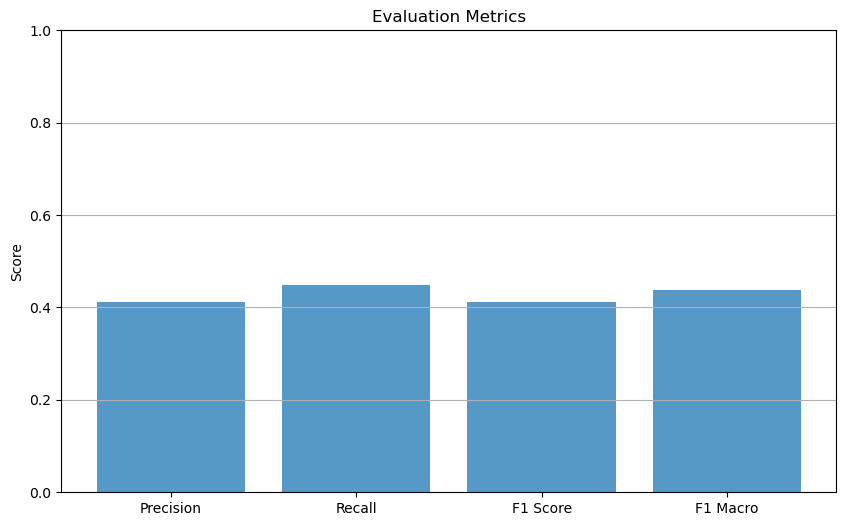

In [34]:
eval_result = trainer.evaluate()
# Create a bar chart for metrics
metrics = ['Precision', 'Recall', 'F1 Score', 'F1 Macro']
values = [eval_result['eval_precision'], eval_result['eval_recall'], eval_result['eval_f1'], eval_result['eval_f1_macro']]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, alpha=0.75)
plt.title("Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)  # Scores are between 0 and 1
plt.grid(axis='y')
plt.show()

In [ ]:
# Save model
model.save_pretrained('./model')

# Save tokenizer
tokenizer.save_pretrained('./tokenizer')

In [20]:
# Load the saved model and tokenizer
model = RobertaForSequenceClassification.from_pretrained('./model')
tokenizer = RobertaTokenizer.from_pretrained('./tokenizer')

# Assuming genre_classes is defined elsewhere, for example:
# genre_classes = ["Mystery", "Fantasy", "Horror", "Sci-Fi", ...] 

# The predict_genres function (as you defined it)
def predict_genres(text, model, tokenizer, genre_classes, threshold=0.5):
    if not isinstance(text, str) or not text.strip():
        raise ValueError("Input text must be a non-empty string.")

    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)

    encoding = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        max_length=512
    )

    encoding = {key: val.to(device) for key, val in encoding.items()}

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
        probs = torch.sigmoid(logits)
        probs = probs.cpu().numpy()[0]

    predicted_genres = [genre_classes[i] + ": " + str(prob) for i, prob in enumerate(probs) if prob >= threshold]
    return predicted_genres

story = """
The Whispering Shadows 

Deep within the ancient woods of Eldenreach, where sunlight struggled to pierce the dense canopy, stood the village of Greystone. Isolated and steeped in superstition, the villagers spoke in hushed tones of the "Whispering Shadows," a legend about spirits who lured the unwary into the forest, never to return.

Aven Callis, a young healer with a mysterious past, had never believed the tales. That was until the night her younger brother, Finn, disappeared into the woods without a trace. Desperate to find him, Aven armed herself with little more than a lantern and a dagger, venturing into the forbidden forest under the pale light of the crescent moon.

The woods were alive with strange noises—branches creaking like whispered warnings and the rustle of unseen movements. The deeper she ventured, the colder the air became, and the shadows seemed to stretch and twist unnaturally. 

"Aven..." a voice called, soft and mournful. She froze, her heart pounding. It was Finn’s voice, but it was wrong—too distant, too hollow.

"Finn?" she called, her voice trembling. She followed the sound, only to find herself at the edge of a glade, where the air shimmered as if the world itself was holding its breath. In the center stood a towering stone monolith, etched with glowing runes that pulsed like a heartbeat.

As Aven approached, the runes flared, and a figure stepped from the shadows. He was tall, cloaked in black, with eyes that gleamed like molten gold. "You seek the boy," he said, his voice smooth as silk. "But do you truly know what he is?"

"What are you talking about?" Aven demanded, clutching her dagger tightly.

The man smiled faintly, his gaze piercing. "The Whispering Shadows don’t take without reason. The boy... he belongs to them now. But there is a way to reclaim him."

Aven’s grip on the dagger tightened. "Tell me how."

"You must walk the Shadow Path," he said, gesturing toward the monolith. "But beware—every step will strip away a part of you. Your past, your secrets, even your soul. Do you have the strength to face the truth?"

Without hesitation, Aven stepped toward the monolith. The moment her hand touched the cold stone, the world around her dissolved into darkness. She found herself on a narrow path lit by ghostly flames, each step revealing fragments of her forgotten memories: a mother’s desperate cries, a brother born under a blood moon, and her own whispered promise to protect him at any cost.

The path led to a massive shadowy figure, its form shifting and writhing. Finn stood before it, his eyes black as obsidian, his voice a hollow echo. "You were supposed to keep me safe."

"I will," Aven said, tears streaming down her face. She plunged her dagger into the heart of the shadow, a blinding light erupting around her.

When the light faded, Aven was back in the glade, Finn unconscious in her arms. The runes on the monolith had gone dark, and the golden-eyed man was nowhere to be seen.

But as she carried Finn back to Greystone, she felt the weight of the shadows in her mind. They had whispered secrets she could never forget, and Aven knew the price of her choice was far from fully paid.
"""

# Predict genres
predicted_genres = predict_genres(
    text=story,
    model=model,
    tokenizer=tokenizer,
    genre_classes=genre_classes,
    threshold= 0.3
)

print("Predicted genres:", predicted_genres)


Predicted genres: ['Adventure: 0.008485725', 'Comedy: 0.0005976711', 'Drama: 0.00033271176', 'Fantasy: 0.038390428', 'Fiction: 0.0075266073', 'Horror: 0.791661', 'Mystery: 0.0033068573', 'Nonfiction: 0.0002585595', 'Romance: 0.0007731407', 'Science Fiction: 0.0047708983']
